In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm, LinearSegmentedColormap, SymLogNorm, ListedColormap, BoundaryNorm
from scipy.interpolate import interp1d, RegularGridInterpolator
import sys
import os
import warnings

helios_source = '../../HELIOS/source'
if helios_source not in sys.path:
    sys.path.append(helios_source)
from species_database import species_lib

# get viridis colormap
cmap = plt.get_cmap('viridis')
cmap.set_bad(color='black')
# set dpi to 200
mpl.rcParams['figure.dpi'] = 200

In [2]:
# habitability params
T_freeze = 273.15 # K
T_boil = np.array([100, 180, 310]) # deg C for P = [1, 10, 100] bar
T_boil = T_boil + T_freeze # K
P_boil = np.array([1, 10, 100]) # bar

In [3]:
# parameters
params = np.array(['P0', 'Tint', 'CplusO', 'CtoO'])

P0s = np.array([1e6, 1e7, 1e8]) # surface pressure in dyn/cm^2
Tints = np.array([50, 75, 100, 125, 150, 200, 250])#, 300, 350]) # internal temperature in K
#Tints = np.array([50, 100, 150, 200, 250])

CplusOs = np.array([1e-3, 1e-2, 1e-1]) #, 3.16e-1, 1e0])
CtoOs = np.array([0.1, 0.59, 1.0])

planets = np.array(['Earth', 'Io'])
adds = ['', '_aN=1e-4', '_aN=1e-2']
# adds = ['_A=0.0', '', '_A=0.2', '_A=0.4', '_A=0.8']

folder = '../output/EqCond+Remove/'

In [4]:
def format_e_nums(num):
    num = f'{num:.2e}'.replace('0', '').replace('.e', 'e').replace('+', '')
    if num[-1] == 'e':
        num = num + '0'
    return num

def format_CtoO_float(f):
    if f == int(f):  # Check if it's a whole number
        return f"{f:.1f}"  # Format as integer if whole
    else:
        return f"{f:.10g}" # Use g format with sufficient precision.

def built_name(loop_over, P0, Tint, CplusO, CtoO, i_param=None, noCond=False, planet='Earth', add=''):
    if noCond:
        noCond = '_NoCond'
    else:
        noCond = ''

    if i_param == 0 or (i_param == None and loop_over in P0s):
        return f'{planet}_P0={format_e_nums(loop_over)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}{add}'
    elif i_param == 1 or (i_param == None and loop_over in Tints):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={loop_over}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(CtoO)}{add}'
    elif i_param == 2 or (i_param == None and loop_over in CplusOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(loop_over)}_CtoO={format_CtoO_float(CtoO)}{add}'
    elif i_param == 3 or (i_param == None and loop_over in CtoOs):
        return f'{planet}_P0={format_e_nums(P0)}_Tint={Tint}{noCond}_CplusO={format_e_nums(CplusO)}_CtoO={format_CtoO_float(loop_over)}{add}'
    else:
        raise ValueError('Invalid loop_over value')

def extract_data(loop_overs, i_P0=0, i_Tint=0, i_CplusO=0, i_CtoO=0, noCond=False, planet='Earth', add=''):
        
    data_dict = {
        "inds": [],
        "PTs": [],
        "nHtots": [],
        "data": [],
        "atoms": [],
        "mols": [],
        "supersats": [],
        "dusts": [],
        "mus": [],
        "convergence": [],
        "n_iter": [],
        "ntots": [],
        "eps_atoms": [],
        "dust_to_gas": [],
        "dust_vol": []
    }

    for i, loop_over in enumerate(loop_overs):
        name = built_name(loop_over, P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], noCond=noCond, add=add, planet=planet)
        #print(name)

        path = folder + name + "/Static_Conc_{var}.dat"
        conv = True
        j = 0

        while True:
            with warnings.catch_warnings():
                warnings.simplefilter("error", UserWarning)
                try:
                    d = np.loadtxt(path.format(var=j), skiprows=3)
                    convergence_conditions = d[-1,2] != 1e-1
                    convergence_conditions = convergence_conditions and not np.all(d[:,0] == 1.001)
                    if convergence_conditions: # if pressure is not 0.1 dyn/cm^2 (=1e-7 bar), then the simulation did not converge
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                        j -= 1
                        break
                    j += 1
                except (FileNotFoundError, UserWarning) as warn:
                    if warn.__class__ == UserWarning:
                        print(f'!GGchem did not converge for {name}!')
                        conv = False
                    j -= 1
                    break


        if i == 0:
            if j == -1:
                for k in range(len(loop_overs)):
                    new_name = built_name(loop_overs[k], P0s[i_P0], Tints[i_Tint], CplusOs[i_CplusO], CtoOs[i_CtoO], noCond=noCond, add=add, planet=planet)
                    new_path = folder + new_name + "/Static_Conc_{var}.dat"
                    try:
                        dimension = np.genfromtxt(new_path.format(var=0), dtype=int,  max_rows=1, skip_header=1)
                        header = np.loadtxt(new_path.format(var=0), skiprows=2, max_rows=1, dtype=str)
                        break
                    except FileNotFoundError:
                        continue
            else:
                dimension = np.genfromtxt(path.format(var=0), dtype=int,  max_rows=1, skip_header=1)
                header = np.loadtxt(path.format(var=j), skiprows=2, max_rows=1, dtype=str)
            
            global n_elem, n_mol, n_dust, n_layers
            n_elem = dimension[0]
            n_mol = dimension[1]
            n_dust = dimension[2]
            n_layers = dimension[3]

            global atom_names, mol_names, dust_names
            atom_names = header[3:4+n_elem]
            mol_names = header[4+n_elem:4+n_elem+n_mol]
            dust_names = header[4+n_elem+n_mol:4+n_elem+n_mol+n_dust]
            dust_names = np.array([dust_name[1:] for dust_name in dust_names]) # Remove first character (S)


        if j == -1:
            d = np.zeros((n_layers, 4+n_elem+n_mol+2*n_dust+n_elem+2))
            d[:,:] = np.nan

            mu = np.zeros(n_layers)
            mu[:] = np.nan

            j = np.nan
        else:
            d = np.loadtxt(path.format(var=j), skiprows=3)
            data_dict["data"].append(d)

            try:
                mu = path[:-21] + f'vertical_mix_{j}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
            except FileNotFoundError:
                print('WARNING: ' + path[:-21] + f'vertical_mix_{j}.dat' + ' not found')
                mu = path[:-21] + f'vertical_mix_{j-1}.dat'
                mu = np.loadtxt(mu, skiprows=1, usecols=3)
                conv = False
        
        data_dict["PTs"].append(np.array([d[:, 2] * 1e-6, d[:, 0]]).T)  # convert pressure from dyn/cm^2 to bar
        data_dict["nHtots"].append(d[:, 1])
        data_dict["atoms"].append(d[:, 3:4+n_elem])
        data_dict["mols"].append(d[:, 4+n_elem:4+n_elem+n_mol])
        data_dict["supersats"].append(d[:, 4+n_elem+n_mol:4+n_elem+n_mol+n_dust])
        data_dict["dusts"].append(d[:, 4+n_elem+n_mol+n_dust:4+n_elem+n_mol+2*n_dust])
        data_dict["eps_atoms"].append(d[:, 4+n_elem+n_mol+2*n_dust:4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_to_gas"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem])
        data_dict["dust_vol"].append(d[:, 4+n_elem+n_mol+2*n_dust+n_elem+1])
        data_dict["inds"].append(i)
        data_dict["mus"].append(mu)

        data_dict["convergence"].append(conv)
        data_dict["n_iter"].append(j)

    #print(data_dict["inds"])
    if not data_dict["inds"]:
        print('No data found')
        data_dict["inds"] = np.empty((1))
        data_dict["PTs"] = np.empty((1, 2))
        data_dict["nHtots"] = np.empty((1))
        data_dict["data"] = np.empty((1, 1, 4+n_elem+n_mol+n_dust+7))
        data_dict["atoms"] = np.empty((1, 1, n_elem))
        data_dict["mols"] = np.empty((1, 1, n_mol))
        data_dict["supersats"] = np.empty((1, 1, n_dust))
        data_dict["dusts"] = np.empty((1, 1, n_dust))
        data_dict["eps_atoms"] = np.empty((1, 1, n_elem))
        data_dict["dust_to_gas"] = np.empty((1, 1))
        data_dict["dust_vol"] = np.empty((1, 1))

    data_dict["inds"] = np.array(data_dict["inds"])
    data_dict["PTs"] = np.array(data_dict["PTs"])
    data_dict["nHtots"] = np.array(data_dict["nHtots"])
    data_dict["data"] = np.array(data_dict["data"])
    data_dict["atoms"] = np.array(data_dict["atoms"])
    data_dict["mols"] = np.array(data_dict["mols"])
    data_dict["supersats"] = np.array(data_dict["supersats"])
    data_dict["dusts"] = np.array(data_dict["dusts"])
    data_dict["eps_atoms"] = np.array(data_dict["eps_atoms"])
    data_dict["dust_to_gas"] = np.array(data_dict["dust_to_gas"])
    data_dict["dust_vol"] = np.array(data_dict["dust_vol"])
    data_dict["convergence"] = np.array(data_dict["convergence"])

    return name, data_dict

def convert(data_dict):

    for i in range(len(data_dict["data"])):
        n_tot = 10**data_dict["data"][i][:, 3:4+n_elem+n_mol]
        n_tot = np.sum(n_tot, axis=1)
        data_dict["ntots"].append(n_tot[:, None])
    data_dict["ntots"] = np.array(data_dict["ntots"])

    # convert atomic abundances (log(cm^-3)) to mixing ratios
    for i, atom in enumerate(data_dict["atoms"]):
        atom = 10**atom
        data_dict["atoms"][i] = atom / data_dict["ntots"][i]
    
    # convert molecular abundances (log(cm^-3)) to mixing ratios
    for i, mol in enumerate(data_dict["mols"]):
        mol = 10**mol
        data_dict["mols"][i] = mol / data_dict["ntots"][i]

    # convert dust abundances (log(cm^-3)) to mixing ratios
    for i in range(len(data_dict["dusts"])):
        data_dict["dusts"][i] = 10**(data_dict["dusts"][i]) * data_dict["nHtots"][i][:, None] / data_dict["ntots"][i]

    data_dict["eps_atoms"] = 10**data_dict["eps_atoms"]
    data_dict["eps_atoms"] = data_dict["eps_atoms"] / (np.sum(data_dict["eps_atoms"], axis=-1)[..., None])

    data_dict["dust_to_gas"] = 10**data_dict["dust_to_gas"]

    return data_dict

In [5]:
def get_tsurf(i_P0, i_CplusO, i_CtoO, noCond=False, planet='Earth', add=''):
    name, data_dict = extract_data(Tints, i_P0=i_P0, i_CplusO=i_CplusO, i_CtoO=i_CtoO, noCond=noCond, planet=planet, add=add)
    tsurfs = []
    for i, data in enumerate(data_dict["PTs"]):
        tsurfs.append(data[0, 1])
    return name, tsurfs

def set_white(ax):
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.tick_params(axis='x', colors='white', which='both')  # Set color for both major and minor ticks
    ax.tick_params(axis='y', colors='white', which='both')  # Set color for both major and minor ticks

    try: # if colorbar is present
        ax.images[0].colorbar.ax.yaxis.label.set_color('white')
        ax.images[0].colorbar.ax.tick_params(axis='y', colors='white', which='both')
        ax.images[0].colorbar.outline.set_color('white')
    except:
        pass

def increase_size(ax, linewidth=3, fontsize=14, legendcols=1, legendloc='best'):
    for l in ax.lines:
        l.set_linewidth(linewidth)
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(linewidth)
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)
    ax.xaxis.label.set_size(fontsize)
    ax.yaxis.label.set_size(fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    if legendloc != 'no':
        ax.legend(fontsize=fontsize, ncols=legendcols, loc=legendloc)

In [6]:
i_CplusO = 1 # i_param = 2 or 'CplusO'
i_CtoO = 1 # i_param = 3 or 'CtoO'
i_planet = 0 # i_param = 'planet'
i_add = 0 # i_param = 'add'

loop_overs = planets #['', '_aN=1e-4', '_aN=1e-2']
i_param = 'planet'

tsurfs = np.zeros((len(loop_overs), len(P0s), len(Tints)))

for i, loop_over in enumerate(loop_overs):
    for i_P0 in range(len(P0s)):
        try:
            if i_param == 2 or i_param == 'CplusO':
                name, tsurf = get_tsurf(i_P0, i, i_CtoO, planet=planets[i_planet], add=adds[i_add])
            elif i_param == 3 or i_param == 'CtoO':
                name, tsurf = get_tsurf(i_P0, i_CplusO, i, planet=planets[i_planet], add=adds[i_add])
            elif i_param == 'planet':
                name, tsurf = get_tsurf(i_P0, i_CplusO, i_CtoO, planet=loop_over, add=adds[i_add])
            elif i_param == 'add':
                name, tsurf = get_tsurf(i_P0, i_CplusO, i_CtoO, planet=planets[i_planet], add=loop_over)
            tsurfs[i, i_P0] = tsurf
        except:
            tsurfs[i, i_P0] = np.nan
            continue

tsurfs = np.array(tsurfs)

# convert name to array split by _
name = [n for n in name.split('_') if 'Tint' not in n]
# concatenate back together without loop_name
if i_param == 2 or i_param == 'CplusO':
    name = [n for n in name if 'CplusO' not in n]
elif i_param == 3 or i_param == 'CtoO':
    name = [n for n in name if 'CtoO' not in n]
name = ', '.join(name).replace('plus', '+').replace('to', '/')
print(name)

Io, P0=1e8, C+O=1e-2, C/O=0.59


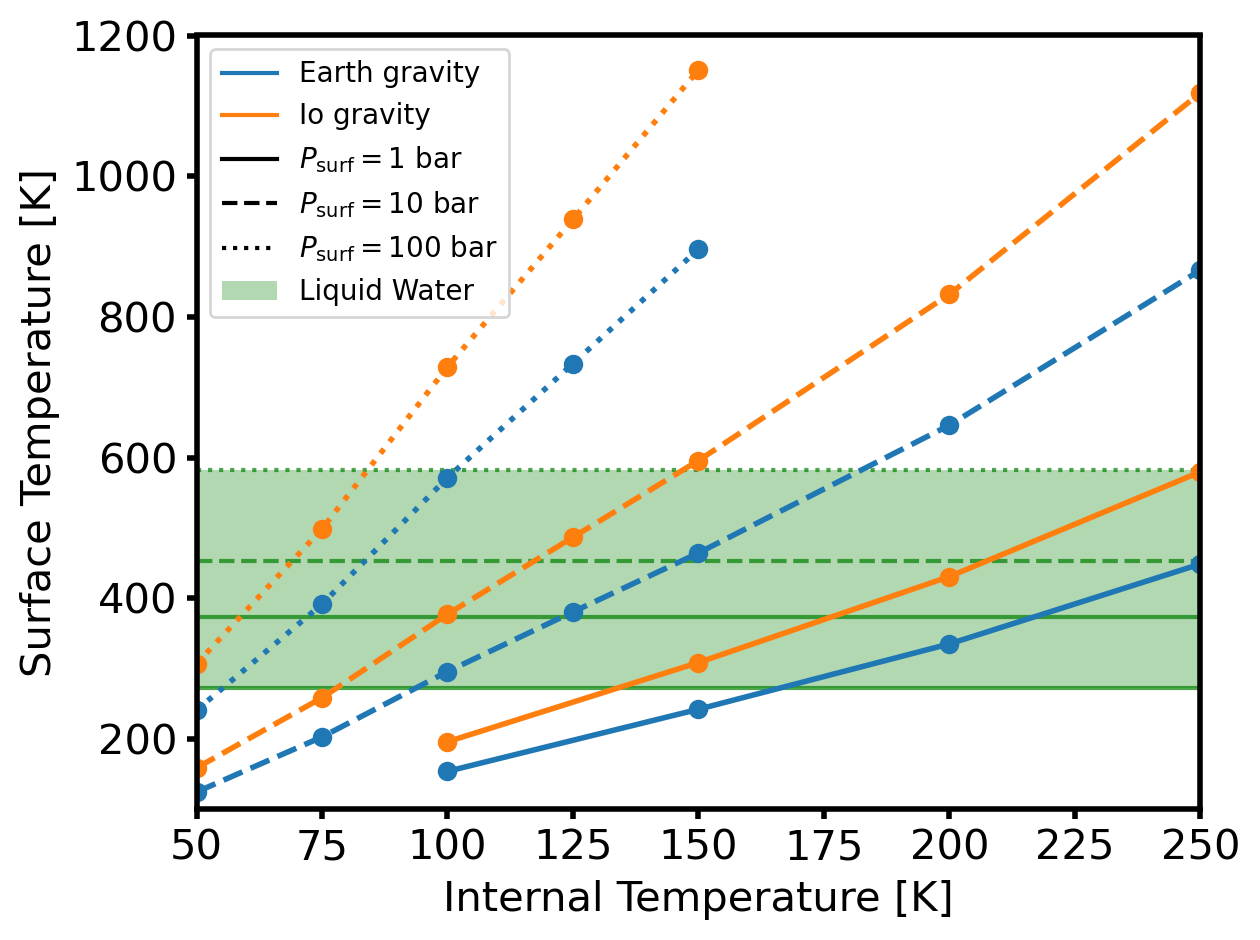

In [7]:
i_P0 = None

if i_P0 is None:
    maybe_loop = np.arange(len(P0s))
else:
    maybe_loop = [i_P0]


linestyles = ['o-', 'o--', 'o:']
colors = ['tab:blue', 'tab:orange', 'tab:red']
colors = colors[:len(loop_overs)]
plt.gca().set_prop_cycle('color', colors)

for i_P0 in maybe_loop:
    #print(loop_overs)
    #print(tsurfs[:,i_P0,:])
    mask = np.isnan(tsurfs[0,i_P0,:])
    plt.plot(Tints[~mask], tsurfs[:,i_P0,~mask].T, linestyles[i_P0]) 
    #, label=[r'X$_\mathrm{N}$ = 0.0' if l == '' else (r'X$_\mathrm{N}$ = ' + f'{l[-4:]}') for l in loop_overs])

xmin = 50
plt.hlines(T_freeze, xmin, Tints[-1], color='green', alpha=0.7, zorder=0)
plt.fill([xmin, xmin, Tints[-1], Tints[-1]], [T_boil[-1], T_freeze, T_freeze, T_boil[-1]], 'green', alpha=0.3, label='Liquid Water', zorder=-5)
for i_P0 in maybe_loop:
    plt.hlines(T_boil[i_P0], xmin, Tints[-1], color='green', linestyle=linestyles[i_P0][1:], alpha=0.7, zorder=0)

plt.ylim(100, 1200)
plt.xlim(xmin, 250)

plt.xlabel('Internal Temperature [K]')
plt.ylabel('Surface Temperature [K]')
plt.title(name.replace(name.split(", ")[1], r'$P_\mathrm{surf}=$' + f'{P0s[i_P0]*1e-6:.0f}bar'))
lgd = plt.legend()

handles, labels = plt.gca().get_legend_handles_labels()
for i in range(len(colors)):
    handles.append(plt.Line2D([0], [0], color=colors[i]))
    labels.append(loop_overs[i] + ' gravity')
    #labels.append(r'$X_\mathrm{N}$ = 0.0' if loop_overs[i] == '' else (r'$X_\mathrm{N}$ = ' + f'{loop_overs[i][-4:]}'))
for i in range(len(linestyles)):
    handles.append(plt.Line2D([0], [0], linestyle=linestyles[i][1:], color='black'))
    labels.append(r'$P_\mathrm{surf}=$' + f'{P0s[i]*1e-6:.0f} bar')
handles.append(handles[0])
labels.append(labels[0])
handles = handles[1:]
labels = labels[1:]
lgd = plt.legend(handles, labels, loc='upper left')


if True:
    plt.title('')
    #set_white(plt.gca())
    increase_size(plt.gca(), linewidth=2, fontsize=15, legendloc='no')

    plt.tight_layout()

    plt.savefig(f'images/Paper1/ComparisonPlanet.svg', transparent=True)

In [8]:
# Calculate internal temperature where surface temperature is equal to freezing point

Tints_freeze = np.zeros((len(loop_overs), len(P0s)))

for i_P0 in range(len(P0s)):
    for i, loop_over in enumerate(loop_overs):
        if np.isnan(tsurfs[i,i_P0,:]).all():
            continue
        mask = np.isnan(tsurfs[i,i_P0,:])
        Tsurf = tsurfs[i,i_P0,~mask]
        Tint = Tints[~mask]

        # interpolate Tsurf to find Tint
        f = interp1d(Tsurf, Tint, bounds_error=False, fill_value='extrapolate')
        Tint_freeze = f(T_freeze)

        Tints_freeze[i,i_P0] = Tint_freeze

        print(f'{loop_over} P0={P0s[i_P0]*1e-6:.0f} bar: Tint_freeze = {Tint_freeze:.2f} K')

print(np.average(Tints_freeze[1,:]/Tints_freeze[0,:]))

print((1821 / 6371)**(3/4))


Earth P0=1 bar: Tint_freeze = 166.57 K
Io P0=1 bar: Tint_freeze = 134.18 K
Earth P0=10 bar: Tint_freeze = 93.86 K
Io P0=10 bar: Tint_freeze = 78.03 K
Earth P0=100 bar: Tint_freeze = 55.32 K
Io P0=100 bar: Tint_freeze = 45.57 K
0.8202062764967631
0.3909099776119995


In [9]:
# connect Tsurf to time evolution

# read in T_eff data from data/T_eff.dat (format: index, time, T_eff)
T_eff = np.loadtxt('../../HELIOS/analyze/data/T_eff.dat')
print(T_eff.shape)

n_time = int(1000/10 + 1)

T_eff = T_eff.reshape((-1,n_time,3))
print(T_eff.shape)
print(T_eff[2,:,0].astype(int))

(701445, 3)
(6945, 101, 3)
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


Time t = 300.95966959047416
> inf K: 0 out of 6945


Text(0.5, 1.0, 'T_eff at t=301 Myr')

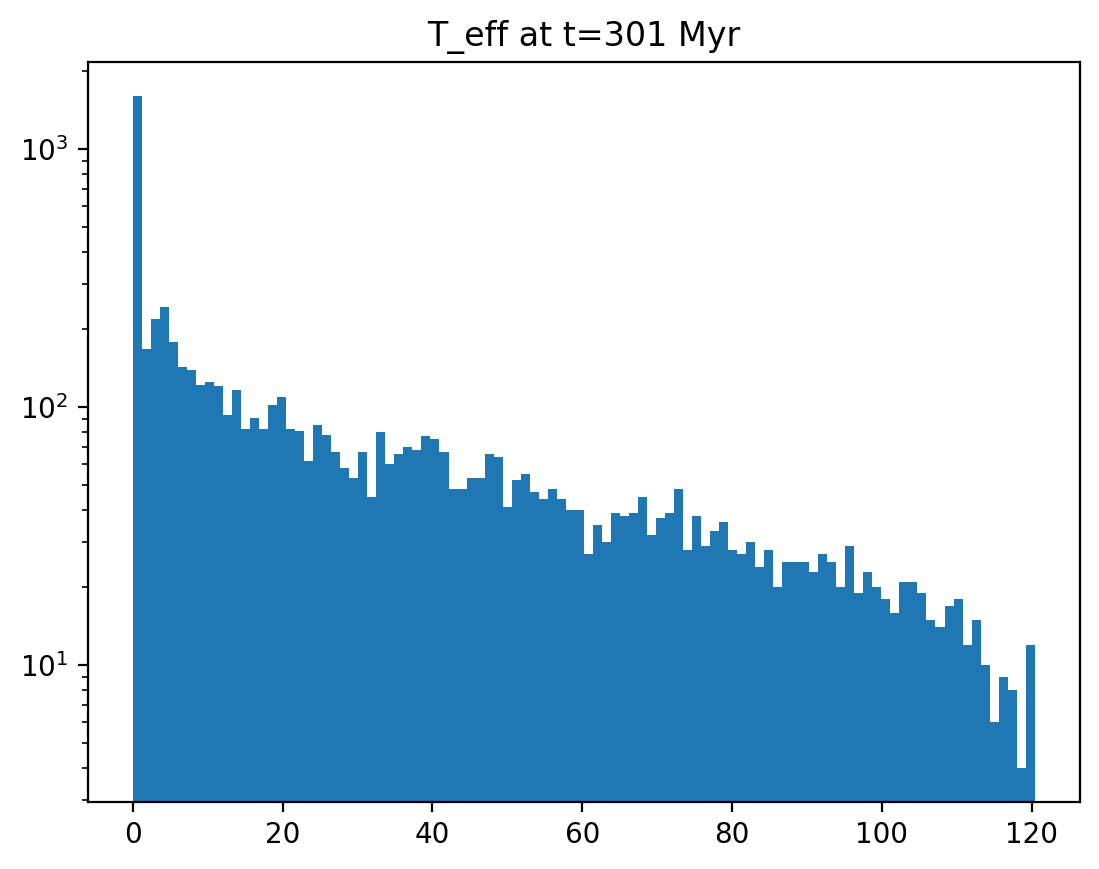

In [10]:
time = 300 # Myr
i_time = np.argmin(np.abs(T_eff[0,:,1] - time))
print('Time t =', T_eff[0,i_time,1])

plot_T_eff = T_eff[:,i_time,2]

T_max = np.inf
T_eff_mask = plot_T_eff < T_max
print(f'> {T_max} K:', np.sum(~T_eff_mask), 'out of', len(plot_T_eff))
plot_T_eff = plot_T_eff[T_eff_mask]


plt.hist(plot_T_eff, bins=100, log=True)
plt.title(f'T_eff at t={T_eff[0,i_time,1]:.0f} Myr')

In [11]:
# calculate time spent in the habitable zone

t_minmax = np.zeros((len(loop_overs), len(P0s), T_eff.shape[0], 2))

for i in range(len(loop_overs)):
    for i_p, P in enumerate(P0s):
        habitable = np.zeros(T_eff.shape[0], dtype=bool)
        for i_t in range(n_time):
            T_eff_i = T_eff[:, i_t, 2]
            T_surf_i = np.interp(T_eff_i, Tints, tsurfs[i, i_p, :])

            mask = np.logical_and(T_surf_i >= T_freeze, T_surf_i <= T_boil[i_p])
            if np.any(mask):
                mask = np.logical_and(~habitable, mask)
                t_minmax[i, i_p, mask, 0] = T_eff[mask, i_t, 1]
                habitable[mask] = True
            
            mask = np.logical_and(habitable, ~mask)
            if np.any(mask):
                t_minmax[i, i_p, mask, 1] = T_eff[mask, i_t, 1]
                habitable[mask] = False


print(t_minmax.min(), t_minmax.max())

time_habitable = t_minmax[:, :, :, 1] - t_minmax[:, :, :, 0]
print(time_habitable[time_habitable!=0.0].min(), time_habitable.max())
print(time_habitable.shape)


0.0 10000.268264840204
-880.7459865320452 880.7459865320452
(2, 3, 6945)


Habitability for an Earth atmosphere
for P0 = 1 bar: 1315 out of 6945 or 18.9% reach the HZ
min: 0.09659129955659385 max: 8.848640237465844
for P0 = 10 bar: 2078 out of 6945 or 29.9% reach the HZ
min: 0.09659129955659385 max: 66.64122044021417
for P0 = 100 bar: 2957 out of 6945 or 42.6% reach the HZ
min: 0.09659129955659385 max: 421.24443672344023


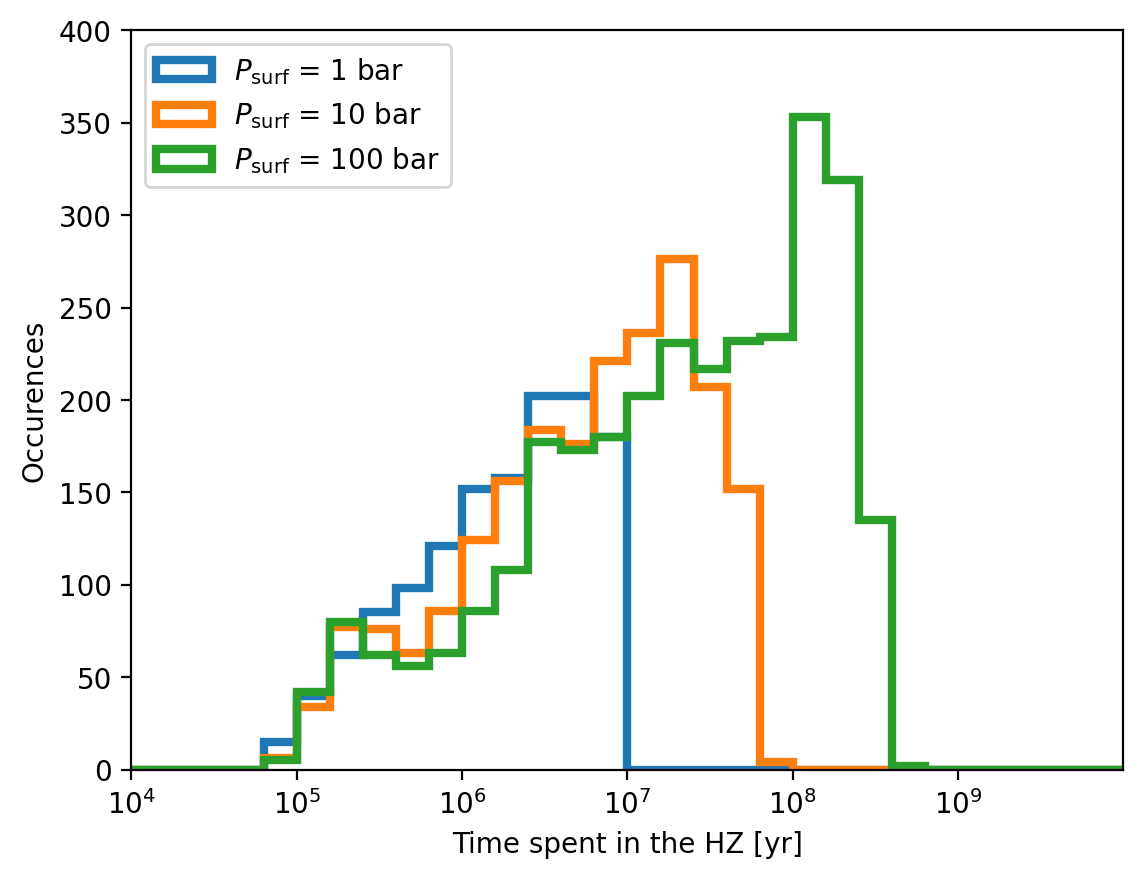

In [12]:
i_loop = 0

hist_min = 4 - 6
hist_max = 10 - 6

print(f'Habitability for an {loop_overs[i_loop]} atmosphere')
for i_p, P in enumerate(P0s):
    mask = time_habitable[i_loop, i_p, :] > 0
    print(f'for P0 = {P*1e-6:g} bar:', np.sum(mask), 'out of', len(mask), f'or {np.sum(mask)/len(mask)*100:.1f}% reach the HZ')
    print('min:', time_habitable[i_loop, i_p, mask].min(), 'max:', time_habitable[i_loop, i_p, mask].max())
    plt.hist(np.log10(time_habitable[i_loop, i_p, mask]), bins=np.linspace(hist_min, hist_max, 31), label=r'$P_\mathrm{surf}$ = ' + f'{P*1e-6:g} bar', histtype='step', linewidth=3)

plt.xticks(np.arange(hist_min, hist_max, 1), [r'$10^{i}$'.format(i=i) for i in np.arange(hist_min, hist_max, 1)+6])
plt.xlim(hist_min, hist_max)
plt.ylim(0,400)

#.title(f'{i_param.replace('plus', '+').replace('to', '/')} = {loop_overs[i_loop]:.0e} atmosphere')
#plt.title(f'{loop_overs[i_loop][1:]} atmosphere')
plt.xlabel('Time spent in the HZ [yr]')
plt.ylabel('Occurences')

plt.legend()

if False:
    plt.title('')
    set_white(plt.gca())
    increase_size(plt.gca(), linewidth=2, fontsize=15, legendloc='upper left')

    plt.tight_layout()

    #plt.ylabel('')
    #plt.gca().set_yticklabels([])

    plt.savefig(f'images/ASES5/TimeInHZ_CplusO={CplusOs[i_CplusO]:.0e}_CtoO={CtoOs[i_CtoO]:g}{adds[i_loop]}.svg', transparent=True)

In [21]:
# get index with the maximum time spent in the HZ
max_index = np.argmax(time_habitable[i_loop, :, :], axis=-1)
print(max_index, time_habitable.shape)
for i, max_ind in enumerate(max_index):
    print(f'Maximum time spent in the HZ: {np.max(time_habitable[i_loop, :, max_ind])} yr for P0 = {P0s[i]*1e-6:.0f} bar')
    print(f'Index: {max_ind}, T_eff_init: {T_eff[max_ind, 0, 2]:.0f} K')

[3030  378 2008] (2, 3, 6945)
Maximum time spent in the HZ: 31.873257211693954 yr for P0 = 1 bar
Index: 3030, T_eff_init: 132 K
Maximum time spent in the HZ: 139.3347480072241 yr for P0 = 10 bar
Index: 378, T_eff_init: 86 K
Maximum time spent in the HZ: 421.24443672344023 yr for P0 = 100 bar
Index: 2008, T_eff_init: 53 K
